In [1]:
library(ggplot2)
suppressPackageStartupMessages(library(extraDistr))
suppressPackageStartupMessages(library(distr))
suppressPackageStartupMessages(require(rstan))
set.seed(2025)


### Q1: Installing and running Stan

In [2]:
# 1
#       mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
# p     0.81    0.01 0.16  0.40  0.73  0.85  0.93  0.99   765    1
# lp__ -3.07    0.03 0.76 -5.39 -3.28 -2.77 -2.56 -2.50   606    1

### Q2: Regression/classification in Stan

In [3]:
# 2
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(dplyr))

df = read.csv(
  "https://raw.githubusercontent.com/UBC-Stat-ML/web447/1e345149a5b698ccdf0a7e9b0aeabec2463c50ca/data/sunspots-SN_m_tot_V2.0.csv",
  sep = ";", header=FALSE) %>%
  mutate(count = ceiling(V4)) %>%
  rename(year = V3) %>%
  filter(year > 2005)

counts = df$count 
time = df$year

In [4]:
init_fun <- function() {
  list(theta1 = 40, theta2 = 1.0, theta3 = 0.25)
}
fit = sampling(stan_model("sunspots.stan"), data=list(N=length(counts), y=counts, t=time), chains=1, iter=2500, init = init_fun, control = list(max_treedepth = 15))
# fit = stan(seed=2025, file="./sunspots.stan", data=list(N=length(counts),y=counts), chains=1, iter=2500, init = init_fun)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000249 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.49 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2500 [  0%]  (Warmup)
Chain 1: Iteration:  250 / 2500 [ 10%]  (Warmup)
Chain 1: Iteration:  500 / 2500 [ 20%]  (Warmup)
Chain 1: Iteration:  750 / 2500 [ 30%]  (Warmup)
Chain 1: Iteration: 1000 / 2500 [ 40%]  (Warmup)
Chain 1: Iteration: 1250 / 2500 [ 50%]  (Warmup)
Chain 1: Iteration: 1251 / 2500 [ 50%]  (Sampling)
Chain 1: Iteration: 1500 / 2500 [ 60%]  (Sampling)
Chain 1: Iteration: 1750 / 2500 [ 70%]  (Sampling)
Chain 1: Iteration: 2000 / 2500 [ 80%]  (Sampling)
Chain 1: Iteration: 2250 / 2500 [ 90%]  (Sampling)
Chain 1: Iteration: 2500 / 2500 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 131.714 seconds (Warm-up)
Chain 1:                31.475 seconds (Sampling)
Chain 1:                

In [8]:
samples = rstan::extract(fit)
theta1_samples = samples$theta1
theta2_samples = samples$theta2
theta3_samples = samples$theta3
theta_samples = data.frame(theta1 = theta1_samples, theta2 = theta2_samples, theta3 = theta3_samples)
lambda_samples =samples$lambda

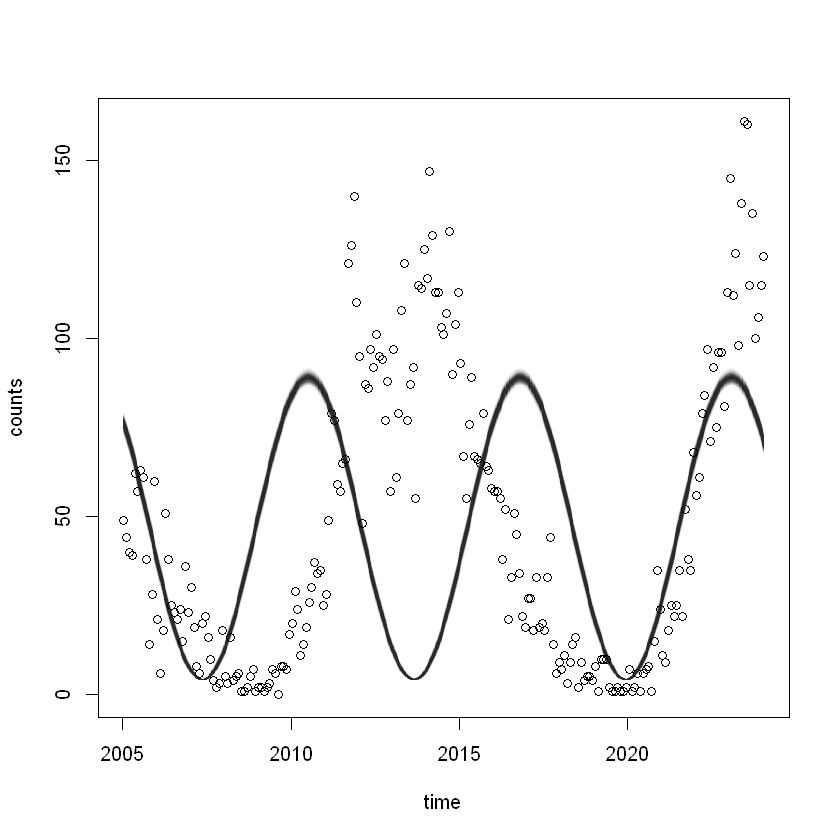

In [ ]:
plot(time, counts, 
      xlab = "time", 
      ylab = "counts")
      
for (i in 1:nrow(lambda_samples)) {
  lines(time, lambda_samples[i,], col = rgb(red = 0, green = 0, blue = 0, alpha = 0.01))
}

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


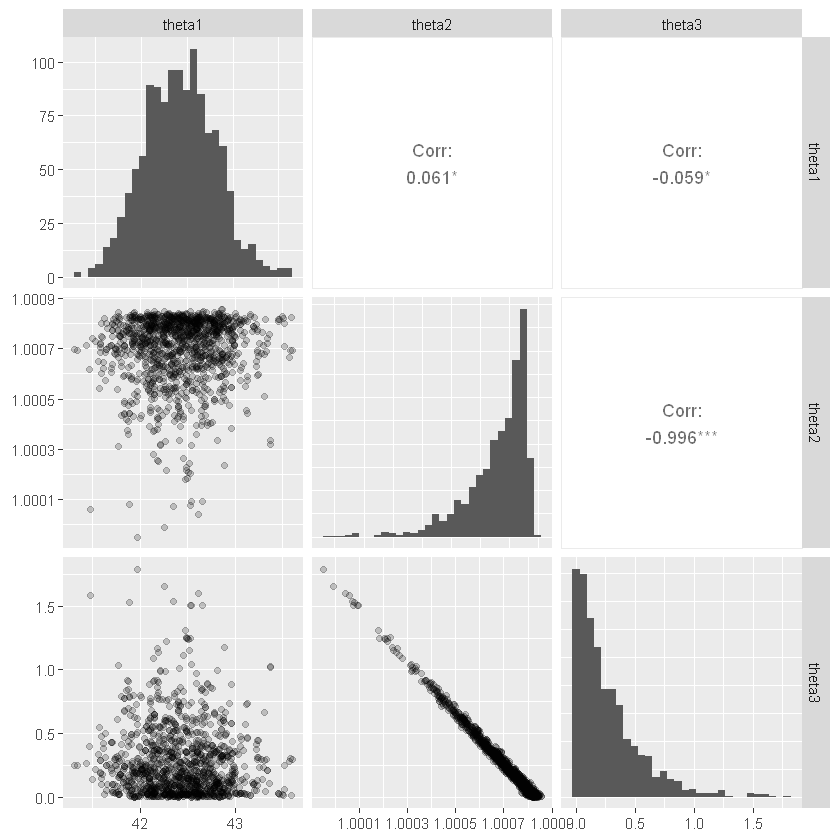

In [7]:
library(GGally)
library(ggplot2)

ggpairs(theta_samples, 
        lower = list(continuous = wrap("points", alpha = 0.2)),
        diag = list(continuous = "barDiag"),
        upper = list(continuous = "cor"),
)

### Q3: A simple MCMC algorithm

In [ ]:
#3
# prior: Beta(alpha, beta)
alpha = 1
beta = 2 

# observations: binomial draws
n_successes = 3 
n_trials = 3

gamma_beta_binomial = function(p) {
    if (p < 0 || p > 1) {
        return(0.0)
    }
    dbeta(p, alpha, beta) * dbinom(x = n_successes, size = n_trials, prob = p)
}

# simple Metropolis-Hastings algorithm (normal proposal)
simple_mh = function(gam, initial_point, n_iters) {
  samples = numeric(n_iters) 
  dim = length(initial_point)
  curr = initial_point
  # gamma(x) == 0 ==> ratio undefined; while gamma(x') = 0 only makes repeated samples
  # exception handling
  if (gam(curr) == 0) {
    print("Invalid initial point!")
    return(samples)
  }
  for (i in 1:n_iters) {
    proposed = rnorm(dim, curr, 1)
    accept_prob = min(1, gam(proposed)/gam(curr))
    u = runif(1, 0, 1)
    if (u <= accept_prob) {
      samples[i] = proposed
      curr = proposed
    }
    else {
      samples[i] = curr
    }
  }
  return(samples)
}

In [24]:
set.seed(2025)
samples = simple_mh(gamma_beta_binomial, 0.5, 1500)

In [25]:
mean(samples)
median(samples)

[1] 0.668554

[1] 0.6783783